In [2]:
# importing the necessary libraries
import pandas as pd
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, MaxPooling1D
from keras.preprocessing.sequence import pad_sequences
from keras.datasets import imdb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/mahas/PycharmProjects/STIRS/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_insta

In [3]:
# Setting up the parameters
maximum_features = 30522  # Maximum number of words to consider as features
maximum_length = 128  # Maximum length of input sequences
word_embedding_dims = 50  # Dimension of word embeddings
no_of_filters = 128  # Number of filters in the convolutional layer
kernel_size = 3  # Size of the convolutional filters
hidden_dim_1 = 128  # Number of neurons in the hidden layer

batch_size = 64  # Batch size for training
epochs = 10  # Number of training epochs
threshold = 0.5  # Threshold for binary classification


In [3]:
DATASET_SIZE = 10_000

In [4]:
df = pd.read_csv("../jigsaw/dataset_text_target.csv")
df_true = df[df.target > 0.5]
df_false = df[df.target <= 0.5]
df = pd.concat([df_true[:DATASET_SIZE//2], df_false[:DATASET_SIZE//2]], axis=0)
mapper = lambda x: 1 if x > 0.5 else 0
df.target = df.target.apply(mapper)

In [5]:
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.comment_text, df.target, test_size=0.2, random_state=42, shuffle=True)


/Users/mahas/PycharmProjects/STIRS/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
#Tokenize and encode the data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [7]:
X_train_encoded = tokenizer.batch_encode_plus(
    x_train.tolist(),
    padding='max_length',
    truncation=True,
    max_length=maximum_length,
    add_special_tokens=True,
    return_tensors='tf',
)
X_test_encoded = tokenizer.batch_encode_plus(
    x_test.tolist(),
    padding='max_length',
    truncation=True,
    max_length=maximum_length,
    add_special_tokens=True,
    return_tensors='tf'
)

2025-05-10 17:11:39.065969: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-10 17:11:39.066003: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-10 17:11:39.066014: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1746877299.066025 11534825 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1746877299.066040 11534825 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
# Building the model
model = Sequential()
# Adding the embedding layer to convert input sequences to dense vectors
model.add(Embedding(maximum_features, word_embedding_dims))

# Adding the first 1D convolutional layer with ReLU activation
model.add(Conv1D(no_of_filters, kernel_size, padding='valid',
                 activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=3))

model.add(Conv1D(no_of_filters, kernel_size, padding='valid',
                 activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=3))

model.add(Conv1D(no_of_filters, kernel_size, padding='valid',
                 activation='relu', strides=1))
model.add(GlobalMaxPooling1D())

# Adding the dense hidden layer with ReLU activation
model.add(Dense(hidden_dim_1, activation='relu'))

# Adding the output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))


In [9]:
from keras.optimizers import AdamW

In [10]:
# Compiling the model with binary cross-entropy loss and Adam optimizer
model.compile(loss='binary_crossentropy',
              optimizer=AdamW(), metrics=['accuracy'])

In [11]:
# Training the model
history = model.fit(X_train_encoded["input_ids"], y_train, batch_size=batch_size,
          epochs=epochs, validation_data=(X_test_encoded["input_ids"], y_test))

Epoch 1/10


2025-05-10 17:11:40.809784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.5237 - loss: 0.6908 - val_accuracy: 0.6850 - val_loss: 0.5959
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8174 - loss: 0.4013 - val_accuracy: 0.8935 - val_loss: 0.2714
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9664 - loss: 0.1045 - val_accuracy: 0.8775 - val_loss: 0.3469
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9890 - loss: 0.0350 - val_accuracy: 0.8755 - val_loss: 0.5198
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9982 - loss: 0.0069 - val_accuracy: 0.8660 - val_loss: 0.6537
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9985 - loss: 0.0054 - val_accuracy: 0.8780 - val_loss: 0.7287
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9992 - loss: 0.0038 - val_accuracy: 0.8710 - val_loss: 0.7983
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9995 - loss: 0.0033 - val_accuracy: 0.870

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 128, 50)          │     1,526,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (64, 126, 128)         │        19,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (64, 42, 128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (64, 40, 128)          │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (64, 13, 128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (64, 11, 128)          │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (64, 128)              │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 128)              │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (64, 1)                │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,981,889 (19.00 MB)

 Trainable params: 1,660,629 (6.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,321,260 (12.67 MB)

In [13]:
# Predicting the probabilities for test data
y_pred_prob = model.predict(X_test_encoded["input_ids"])

# Converting the probabilities to binary classes based on a threshold
y_pred = (y_pred_prob > threshold).astype(int)

# Calculating the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Printing the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.869
Precision: 0.8524436090225563
Recall: 0.8962450592885376
F1-score: 0.873795761078998


In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86       988
           1       0.85      0.90      0.87      1012

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



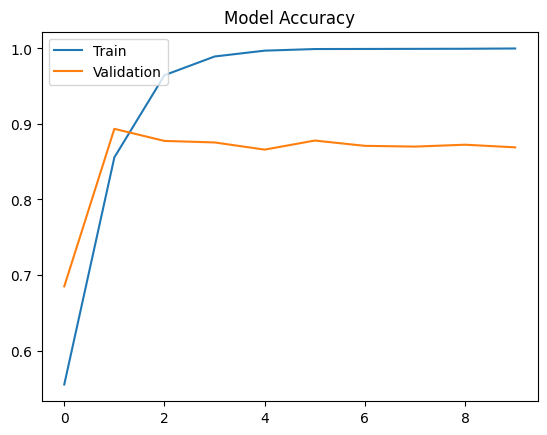

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")

In [ ]:
import json
with open("result.json", "w") as f:
    json.dump(history.history, f, indent=2)

In [18]:
import json
result = json.load(open("result.json"))

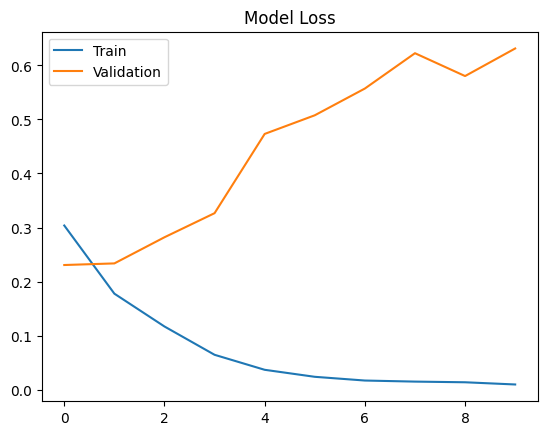

In [20]:

plt.plot(result["loss"])
plt.plot(result["val_loss"])
plt.title("Model Loss")
plt.legend(["Train", "Validation"], loc="upper left")

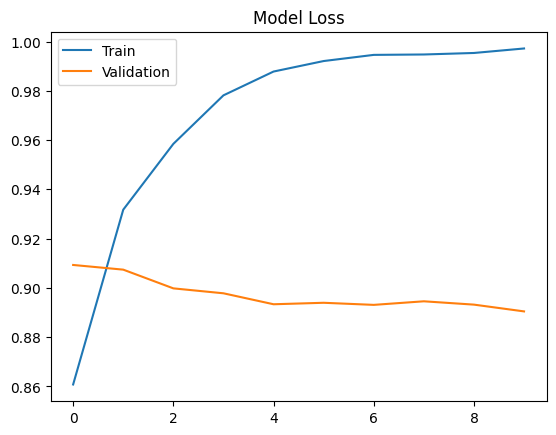

In [21]:

plt.plot(result["accuracy"])
plt.plot(result["val_accuracy"])
plt.title("Model Loss")
plt.legend(["Train", "Validation"], loc="upper left")

In [ ]:
model.save("cnn_model_trained")